# Integral Equation Model Comparisons
Purpose of this notebook is to EOS calculations for comparisons to George Petrov's Average Atom model, and Morales EOS Hydrogen paper

[https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.81.021202)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n, P_Ideal_Fermi_Gas, E_Ideal_Fermi_Gas 


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")

ModuleNotFoundError: No module named 'mendeleev'


#### Load Morales Data

In [2]:
Morales_file = "Morales_EOS_data.dat"
Morales_df = read_csv(Morales_file, delim_whitespace=True, header=4)
Morales_EAU  = Morales_df['E[AU]']
Morales_PGPa = Morales_df['P[GPa]']
Morales_TK   = Morales_df['T[K]']
Morales_PMbar =  1e-2*Morales_PGPa
Morales_TeV = Morales_TK/eV_to_K

### Set Parameters in Paper and Plot

In [3]:
name = 'Hydrogen'
Z, A = 1,1 

Te_eV_list = np.geomspace(np.array(Morales_TeV)[0], 1000, num=20) #np.array(GP_Te_eV) # eV
Ti_eV_list = Te_eV_list
ni_cc = 5.98e23
ni_AU = ni_cc/cm_to_AU**3

ri_cm = rs_from_n(ni_cc)  # cm
ri_AU = ri_cm*cm_to_AU    # AU 

#### Run Ornstein-Zernike Closure

In [16]:
# Define plasma method to use
name = 'OZ - th  Pauli'
plasma_func = lambda T_eV, ni_cc: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Z, find_βuee=True,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'thermal'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':1e3,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})

# Helpful unit functions
P_hnc_to_AU   = lambda P_hnc: (P_hnc/ri_AU**3) 
P_hnc_to_bar  = lambda P_hnc: P_hnc_to_AU(P_hnc) *  AU_to_bar 
P_hnc_to_Mbar = lambda P_hnc: 1e-6*P_hnc_to_bar(P_hnc)
P_hnc_to_GPa  = lambda P_hnc: P_hnc_to_bar(P_hnc) * 1e5 / 1e9 
E_hnc_to_eV   = lambda E_hnc: E_hnc/plasma.hnc.rho[0] * AU_to_eV

P_hnc_to_AU = np.vectorize(P_hnc_to_AU)
P_hnc_to_bar = np.vectorize(P_hnc_to_bar)
P_hnc_to_Mbar = np.vectorize(P_hnc_to_Mbar)
P_hnc_to_GPa = np.vectorize(P_hnc_to_GPa)
E_hnc_to_eV = np.vectorize(E_hnc_to_eV)

# Create new thermodynamic variable generator
def excess_energy_density_matrix(plasma, d_βu ): # Defining   d_βu = dβ_c u/dβ = -T^2 d β_c u/dT
    g_matrix = plasma.hnc.h_r_matrix+1
    rho_matrix = plasma.hnc.rho[:,np.newaxis] * plasma.hnc.rho[np.newaxis,:]
    r = plasma.hnc.r_array[np.newaxis,np.newaxis,:]
    dr = plasma.hnc.del_r
    
    u_ex_matrix = np.sum(2*π*rho_matrix[:,:,np.newaxis]*d_βu*g_matrix*r**2*dr,axis=2)
    return u_ex_matrix

def ideal_energy_density_matrix(plasma, d_β):
    u_i_id   = 3/2 * plasma.hnc.rho[0] * plasma.qsp.Ti
    u_e_c_id = 3/2 * plasma.hnc.rho[1] * plasma.qsp.Te_c
    u_e_id   = u_e_c_id * ( d_β )#  + 0*mass) # IGNORING MASS RUNNING FOR NOW
    return np.diag([u_i_id, u_e_id ])

def chemical_potential_addition():
    return None


def get_U_matrices(plasma_pair):
    plasma, plasma_ε = plasma_pair
    plasma_ε.run_hnc(c_s_k_guess = plasma.hnc.c_s_k_matrix.copy())
    dT_AU = plasma.Ti - plasma_ε.Ti
    T_AU = plasma.Ti
    
    # Now we need   d_βu = dβ_c u/dβ = -T^2 d β_c u/dT
    d_βu_AU = -T_AU**2*(plasma.hnc.βu_r_matrix - plasma_ε.hnc.βu_r_matrix)/dT_AU
    d_β  = -T_AU**2*( 1/plasma.qsp.Te_c - 1/plasma_ε.qsp.Te_c)/dT_AU

    # Get energies
    U_ex = excess_energy_density_matrix(plasma, d_βu_AU )
    U_id = ideal_energy_density_matrix(plasma, d_β)
    U_standard = plasma.hnc.energy_density_matrix()
    
    # Convert units
    E_id_AU, E_ex_AU, E_st_AU, E_AU = U_id/plasma.hnc.rho[0], U_ex/plasma.hnc.rho[0], U_standard/plasma.hnc.rho[0], (U_id + U_ex)/plasma.hnc.rho[0]
    E_id_eV, E_ex_eV, E_st_eV, E_eV = np.array([E_id_AU, E_ex_AU, E_st_AU, E_AU])*AU_to_eV
    return E_id_eV, E_ex_eV, E_st_eV, E_eV


def get_P_matrices(plasma_pair):
    plasma, plasma_ε = plasma_pair
    plasma_ε.run_hnc(c_s_k_guess = plasma.hnc.c_s_k_matrix.copy())
    dn_AU = plasma.ni_AU - plasma_ε.ni_AU
    n_AU = plasma.ni_AU
    
    # Get pressures
    P_ex = plasma.hnc.excess_pressure_matrix()
    P_id = np.diag(plasma.hnc.rho*plasma.hnc.Temp_list)
    
    dβu_dlnn_AU = n_AU*(plasma.hnc.βu_r_matrix - plasma_ε.hnc.βu_r_matrix)/dn_AU

    P_nonstandard = excess_energy_density_matrix(plasma, plasma.Ti * dβu_dlnn_AU  )
    # Convert units
    P_standard = P_ex + P_id
    P_id_Mbar, P_ex_Mbar, P_standard_Mbar, P_Mbar = P_hnc_to_Mbar([P_id, P_ex, P_standard, P_standard+P_nonstandard])
    return P_id_Mbar, P_ex_Mbar, P_standard_Mbar, P_Mbar


def get_U(plasma, ε=1e-6):
    plasma_pair = [plasma, plasma_func(plasma.Ti_eV*(1-ε), plasma.ni_cc)]
    U_id_matrix, U_ex_matrix, U_st_matrix, U_matrix = get_U_matrices(plasma_pair)
    return np.sum(U_id_matrix), np.sum(U_ex_matrix), np.sum(U_st_matrix), np.sum(U_matrix)

def get_P(plasma, ε=1e-6):
    plasma_pair = [plasma, plasma_func(plasma.Ti_eV, plasma.ni_cc*(1-ε))]
    P_id_matrix, P_ex_matrix, P_st_matrix, P_matrix = get_P_matrices(plasma_pair)
    return np.sum(P_id_matrix), np.sum(P_ex_matrix), np.sum(P_st_matrix), np.sum(P_matrix)


# get_U_matrices(plasma_pair_func(1e4))

### Compute all plasma models for list of densities

In [17]:
EOS_list = []

for T_eV in Te_eV_list:
    plasma = plasma_func(T_eV, ni_cc)
    E_id_eV, E_ex_eV, E_st_eV, E_eV         = get_U(plasma)
    P_id_Mbar, P_ex_Mbar, P_st_Mbar, P_Mbar = get_P(plasma)
    EOS_list.append( [[E_id_eV, E_ex_eV, E_st_eV, E_eV],[P_id_Mbar, P_ex_Mbar, P_st_Mbar, P_Mbar]] )
    
EOS_list = np.array(EOS_list)

Te_in_eV: 0.172
Ti_in_eV: 0.172


/home/zach/plasma/hnc/hnc/PIE.py:150: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))
/home/zach/plasma/hnc/hnc/PIE.py:157: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 6.808e+01
Exiting status 0, reverting to best index so far: 810
Final iter:811, Total Error: 9.946e-09
Te_in_eV: 0.172
Ti_in_eV: 0.172
0: Initial condition Total Error: 6.808e+01
Exiting status 0, reverting to best index so far: 810
Final iter:811, Total Error: 9.950e-09
Te_in_eV: 0.272
Ti_in_eV: 0.272
Te_in_eV: 0.272
Ti_in_eV: 0.272
0: Initial condition Total Error: 4.685e+01
Exiting status 0, reverting to best index so far: 546
Final iter:547, Total Error: 9.795e-09
Te_in_eV: 0.272
Ti_in_eV: 0.272
0: Initial condition Total Error: 4.685e+01
Exiting status 0, reverting to best index so far: 546
Final iter:547, Total Error: 9.795e-09
Te_in_eV: 0.429
Ti_in_eV: 0.429
Te_in_eV: 0.429
Ti_in_eV: 0.429
0: Initial condition Total Error: 3.184e+01
Exiting status 0, reverting to best index so far: 371
Final iter:372, Total Error: 9.775e-09
Te_in_eV: 0.429
Ti_in_eV: 0.429
0: Initial condition Total Error: 3.184e+01
Exiting status 

/home/zach/plasma/hnc/hnc/PIE.py:151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]
/home/zach/plasma/hnc/hnc/PIE.py:151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]


Te_in_eV: 41.059
Ti_in_eV: 41.059
0: Initial condition Total Error: 4.207e-01
Exiting status 0, reverting to best index so far: 26
Final iter:27, Total Error: 5.923e-09
Te_in_eV: 41.059
Ti_in_eV: 41.059
0: Initial condition Total Error: 4.207e-01
Exiting status 0, reverting to best index so far: 26
Final iter:27, Total Error: 5.923e-09
Te_in_eV: 64.788
Ti_in_eV: 64.788
Te_in_eV: 64.788
Ti_in_eV: 64.788
0: Initial condition Total Error: 2.601e-01
Exiting status 0, reverting to best index so far: 25
Final iter:26, Total Error: 7.479e-09
Te_in_eV: 64.788
Ti_in_eV: 64.788
0: Initial condition Total Error: 2.601e-01
Exiting status 0, reverting to best index so far: 25
Final iter:26, Total Error: 7.479e-09
Te_in_eV: 102.230
Ti_in_eV: 102.230
Te_in_eV: 102.230
Ti_in_eV: 102.230
0: Initial condition Total Error: 1.574e-01
Exiting status 0, reverting to best index so far: 24
Final iter:25, Total Error: 9.409e-09
Te_in_eV: 102.230
Ti_in_eV: 102.230
0: Initial condition Total Error: 1.574e-01
Exi

### Energy per Atom

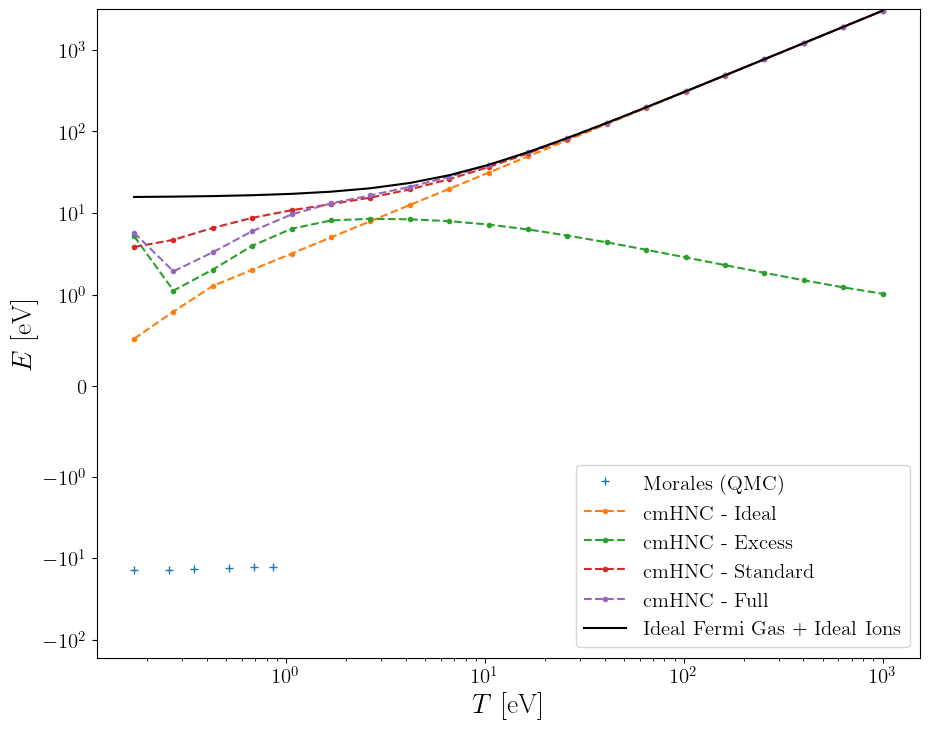

In [6]:
from hnc.hnc.misc import Fermi_Energy

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_EAU*AU_to_eV, '+', label='Morales (QMC)')

# Plot Energy
axs[0].plot(Te_eV_list, EOS_list[:,0,0],'--.', label="cmHNC - Ideal")
axs[0].plot(Te_eV_list, EOS_list[:,0,1],'--.', label="cmHNC - Excess")
axs[0].plot(Te_eV_list, EOS_list[:,0,2],'--.', label="cmHNC - Standard")
axs[0].plot(Te_eV_list, EOS_list[:,0,3],'--.', label="cmHNC - Full")

# Plot Fermi Gas Energy
E_ideal_eV_func = lambda Te_eV, Ti_eV: E_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_eV + 3/2*Ti_eV
E_ideal_eV_func = np.vectorize(E_ideal_eV_func)

Ee_ideal_eV = [E_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_eV for Te_eV in Te_eV_list]
Ei_ideal_eV = 3/2*Ti_eV_list

# axs[0].plot(Te_eV_list, Ee_ideal_eV,'k--', label="Ideal Fermi Gas"  ) 
# axs[0].plot(Te_eV_list, 3/5*Fermi_Energy(ni_AU)*np.ones_like(Te_eV_list)*AU_to_eV,'k--.', label="Degnerate Fermi Gas"  ) 
# axs[0].plot(Te_eV_list, Ei_ideal_eV,'k-.', label="Ideal Gas"  ) 
axs[0].plot(Te_eV_list, Ee_ideal_eV + Ei_ideal_eV,'k-', label="Ideal Fermi Gas + Ideal Ions"  ) 

for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$E$ [eV]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()

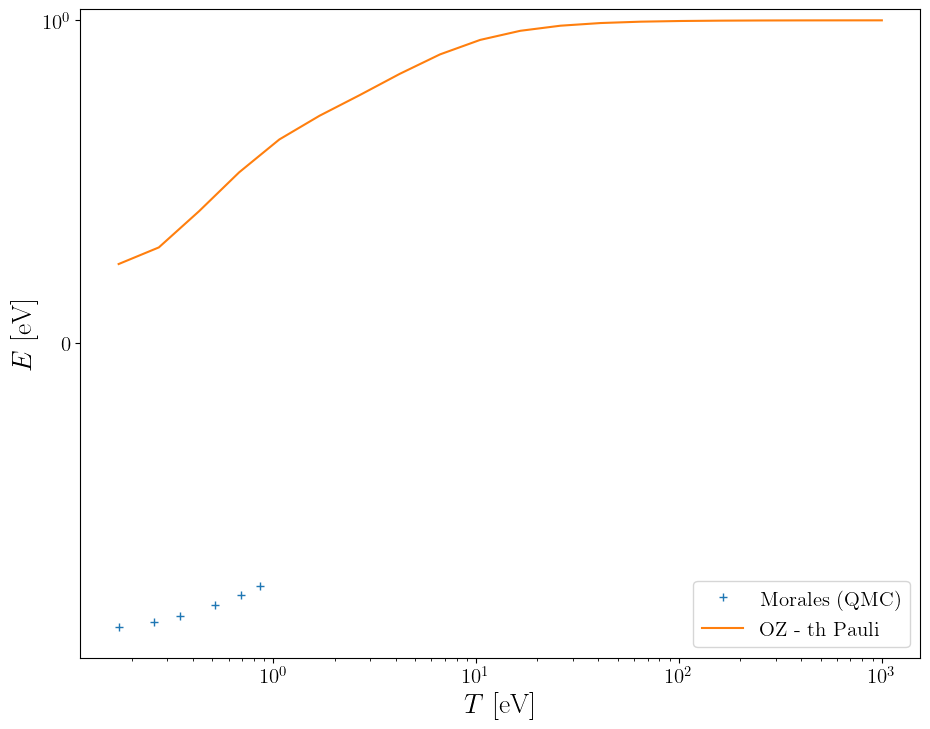

In [7]:
from hnc.hnc.misc import Fermi_Energy

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_EAU*AU_to_eV/E_ideal_eV_func(Morales_TeV,Morales_TeV), '+', label='Morales (QMC)')

# Plot Energy
axs[0].plot(Te_eV_list, EOS_list[:,0,2]/E_ideal_eV_func(Te_eV_list,Te_eV_list), label=name)

for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$E$ [eV]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()

### Plot Pressures

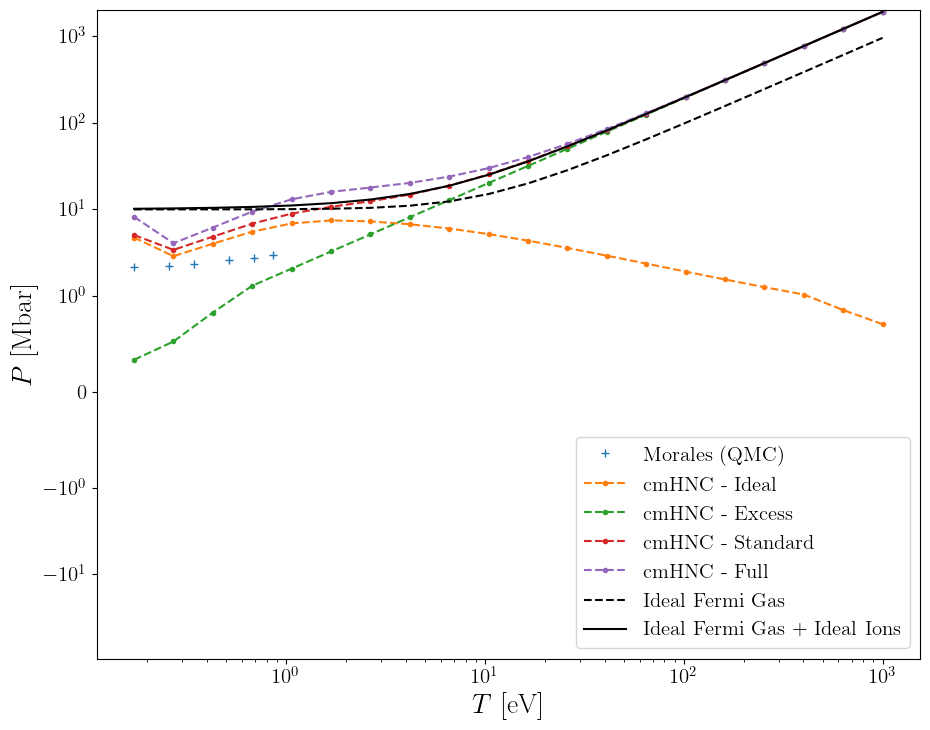

In [8]:

fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_PMbar, '+', label='Morales (QMC)')

# Plot Pressure 
axs[0].plot(Te_eV_list, EOS_list[:,1,0],'--.', label="cmHNC - Ideal")
axs[0].plot(Te_eV_list, EOS_list[:,1,1],'--.', label="cmHNC - Excess")
axs[0].plot(Te_eV_list, EOS_list[:,1,2],'--.', label="cmHNC - Standard")
axs[0].plot(Te_eV_list, EOS_list[:,1,3],'--.', label="cmHNC - Full")

# Plot Fermi Pressure
Pe_ideal_Mbar = [P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_bar/1e6 for Te_eV in Te_eV_list]
Pi_ideal_Mbar = Ti_eV_list*eV_to_AU*ni_AU*AU_to_bar/1e6

axs[0].plot(Te_eV_list, Pe_ideal_Mbar,'k--', label="Ideal Fermi Gas"  ) 
axs[0].plot(Te_eV_list, Pe_ideal_Mbar + Pi_ideal_Mbar,'k-', label="Ideal Fermi Gas + Ideal Ions"  ) 

for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$P$ [Mbar]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()

#### Plot Pressure over Ideal Pressure

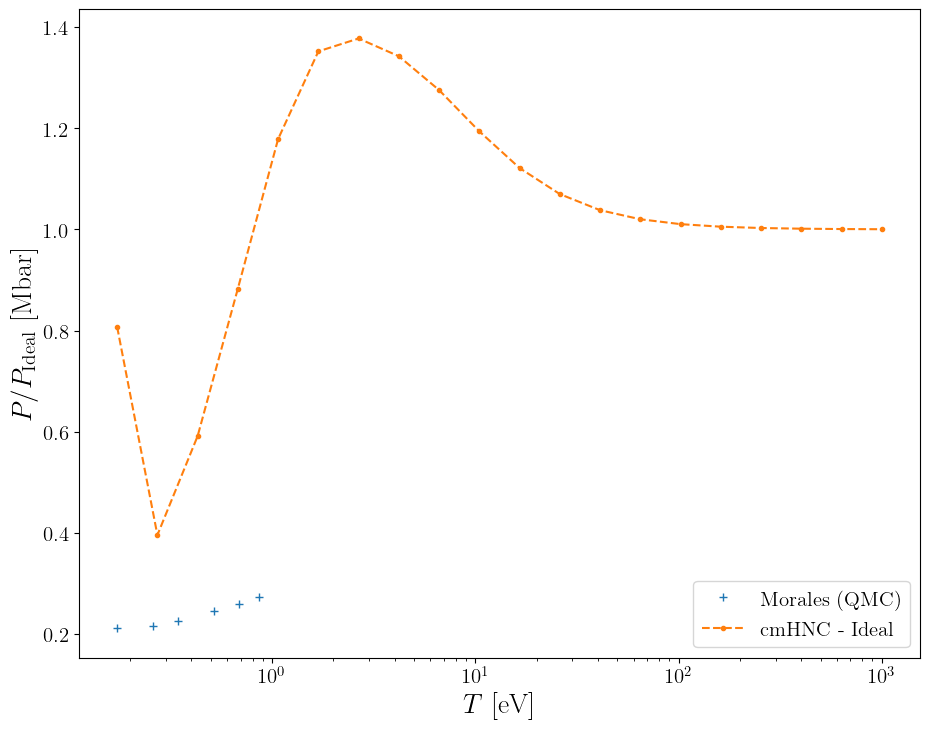

In [15]:
fig, axs = plt.subplots( figsize=(10,8))
axs = np.array([axs])
# fig.suptitle(r"$T_i $ eV", fontsize=25, y=0.9)

# Plot Fermi Pressure
P_ideal_Mbar_func = lambda Te_eV, Ti_eV: P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_AU)*AU_to_bar/1e6 + Ti_eV*eV_to_AU*ni_AU*AU_to_bar/1e6
P_ideal_Mbar_func = np.vectorize(P_ideal_Mbar_func)

#Plot Morales data
axs[0].plot(Morales_TeV, Morales_PMbar/[P_ideal_Mbar_func(T_eV, T_eV) for T_eV in Morales_TeV], '+', label='Morales (QMC)')

# Plot Pressure ratio
axs[0].plot(Te_eV_list, EOS_list[:,1,3]/P_ideal_Mbar_func(Te_eV_list,Te_eV_list),'--.', label="cmHNC - Ideal")
# axs[0].plot(Te_eV_list, EOS_list[:,1,1],'--.', label="cmHNC - Excess")
# axs[0].plot(Te_eV_list, EOS_list[:,1,2],'--.', label="cmHNC - Standard")
# axs[0].plot(Te_eV_list, EOS_list[:,1,3],'--.', label="cmHNC - Full")


for ax in axs:
    ax.legend(fontsize=15, loc='lower right')
    ax.set_xscale('log')
    # ax.set_yscale('symlog', linthresh=1)
    # ax.set_yscale('log')
    # ax.set_ylim(0, 20)
    ax.set_ylabel(r"$P/P_{\rm Ideal}$ [Mbar]", fontsize=20)
    ax.set_xlabel(r"$T$ [eV]", fontsize=20)
    ax.tick_params(labelsize=15)
plt.tight_layout()